#Paquetes necesarios

In [1]:
import cv2  
import math 
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO


# Dataset

In [4]:

from roboflow import Roboflow
rf = Roboflow(api_key="4f30PcoEDIzjaToViv6n")
project = rf.workspace("project-n3wam").project("project-ttd5y")
dataset = project.version(1).download("yolov8")

#Luego en la carpeta datasets
    #from ultralytics import YOLO
    # Inicializar el modelo YOLO pre-entrenado
    #model = YOLO('yolov8n')  # Puedes especificar 'yolov5s', 'yolov5m', 'yolov5l', o 'yolov5x'

    # Cargar datos y comenzar el entrenamiento
    #results = model.train(data='data.yaml', epochs=100, imgsz=640, device='mps')

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.203, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Project-1 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 2391.51it/s]


# Detector sin YOLO

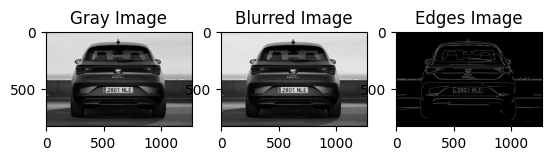

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Texto en la matrícula: 2801 NLE


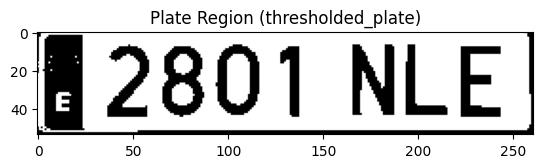

Imagen con detecciones de matrículas y texto guardada en: ./Filter/filtrado_con_matriculas_ocr.jpg


In [6]:
import easyocr

image_path = './Data/2.jpg'
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 100)

# Plot de la imagen en escala de grises
plt.subplot(131)
plt.imshow(gray, cmap='gray')
plt.title('Gray Image')

# Plot de la imagen con desenfoque
plt.subplot(132)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')

# Plot de la imagen con detección de bordes
plt.subplot(133)
plt.imshow(edges, cmap='gray')
plt.title('Edges Image')

plt.show()

# Encontrar contornos en la imagen
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Inicializar el lector OCR
reader = easyocr.Reader(['en'])

# Para cada contorno
for contour in contours:
    # Calcular el perímetro del contorno
    perimeter = cv2.arcLength(contour, True)

    # Aproximar el contorno por un polígono
    epsilon = 0.03 * perimeter  # Ajusta este valor según la imagen
    approx = cv2.approxPolyDP(contour, epsilon, True)

    # Si el polígono tiene cuatro esquinas y un área mínima, asumimos que es una matrícula
    if len(approx) >= 4 and cv2.contourArea(contour) >= 300:
        # Obtener las coordenadas de la caja delimitadora de la matrícula
        x, y, w, h = cv2.boundingRect(approx)

        # Recortar la región de la matrícula
        plate_region = img[y:y+h, x:x+w]

        # Convertir la región de la matrícula a escala de grises
        plate_gray = cv2.cvtColor(plate_region, cv2.COLOR_BGR2GRAY)

        _, thresholded_plate = cv2.threshold(plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Realizar la detección de texto en la región de la matrícula
        result = reader.readtext(thresholded_plate, detail=5, text_threshold=0.8)

        # Mostrar el texto detectado
        if result:
            text = result[0][1]
            print(f"Texto en la matrícula: {text}")

            # Mostrar la caja delimitadora de la matrícula
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Mostrar la región de la matrícula (plate_gray) en un plot
            plt.imshow(thresholded_plate, cmap='gray')
            plt.title('Plate Region (thresholded_plate)')
            plt.show()

# Guardar la imagen con las detecciones de matrículas
output_image_path = './Filter/filtrado_con_matriculas_ocr.jpg'
cv2.imwrite(output_image_path, img)

print(f"Imagen con detecciones de matrículas y texto guardada en: {output_image_path}")

# Detector de Matriculas (Imagenes)

In [43]:
# Version 1: Deteccion de coche y sobre coche el texto
import cv2
import math
import easyocr
from ultralytics import YOLO

# Inicializar YOLO y cargar el modelo
model = YOLO('./Model/yolov8n.pt')


# Nombre de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]


# Inicializar EasyOCR
reader = easyocr.Reader(['en'])  # Puedes agregar más idiomas si es necesario

# Ruta de la imagen con las detecciones de coches
image_path = './Data/2.jpg'  # Ruta de la imagen con coches detectados

# Cargar la imagen
img = cv2.imread(image_path)

# Realizar la detección de coches en la imagen
results = model(img)

# Para cada detección de coche
for r in results:
    boxes = r.boxes

    for box in boxes:
        cls = int(box.cls[0])

        # Filtrar para mostrar solo los automóviles (clase 'car')
        if classNames[cls] == "car":
            # Obtener datos de la detección
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # convertir a enteros

            # Obtener la región donde se detectó el coche
            car_img = img[y1:y2, x1:x2]

            # Realizar la detección de matrículas en la región del coche
            result = reader.readtext(car_img)

            # Mostrar resultados de la detección de matrículas
            for detection in result:
                print(f"Matrícula detectada: {detection[1]}")



0: 416x640 1 car, 1 truck, 15.1ms
Speed: 2.2ms preprocess, 15.1ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 640)


Matrícula detectada: Leol
Matrícula detectada: 2801 NLE


In [44]:
# Version 2: Deteccion de Matriculas
import cv2
import math
from ultralytics import YOLO

# Inicializar YOLO y cargar el modelo entrenado específicamente para matrículas
model = YOLO('./Model/last.pt')

# Nombre de las distintas clases
classNames = ["matricula-ES"]

# Ruta de la imagen con las detecciones de coches
image_path = './Data/6.jpg'  # Ruta de la imagen con coches detectados

# Cargar la imagen
img = cv2.imread(image_path)

# Realizar la detección de matrículas en la imagen
results = model(img)

# Para cada detección de matrícula
for r in results:
    boxes = r.boxes

    for box in boxes:
        cls = int(box.cls[0])

        # Filtrar para mostrar solo las matrículas
        if classNames[cls] == "matricula-ES":
            # Obtener datos de la detección
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # convertir a enteros

            # Mostrar la caja delimitadora de la matrícula
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
            cv2.putText(img, "Matricula", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# Guardar la imagen con las detecciones de matrículas
output_image_path = './Filter/filtrado_con_matriculas.jpg'
cv2.imwrite(output_image_path, img)

print(f"Imagen con detecciones de matrículas guardada en: {output_image_path}")



0: 448x640 4 license_plates, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Imagen con detecciones de matrículas guardada en: ./Filter/filtrado_con_matriculas.jpg


In [ ]:
# Versión 3: Deteccion de matriculas Imagenes (Sin importancia de la procedencia)

import os
import cv2
import easyocr
import math
from ultralytics import YOLO
# Directorio de entrada y salida
input_directory = './Data/'
output_directory = './Filter/'

# Obtener la lista de archivos en el directorio de entrada
image_files = os.listdir(input_directory)

# Inicializar YOLO para la detección de coches
car_model = YOLO('./Model/yolov8n.pt')

# Inicializar YOLO para la detección de matrículas
plate_model = YOLO('./Model/last.pt')

# Nombre de las distintas clases
car_classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]
plate_classNames = ["pl_license_plate"]

# Procesar cada imagen en la carpeta de entrada
for image_file in image_files:
    image_path = os.path.join(input_directory, image_file)
    output_image_name = image_file.replace('.jpg', '_detected_plates.jpg')  # Nombre de la imagen de salida

    # Cargar la imagen
    img = cv2.imread(image_path)

    # Realizar la detección de coches en la imagen con YOLO
    car_results = car_model(img)

    # Para cada detección de coche
    for car_r in car_results:
        boxes = car_r.boxes

        for box in boxes:
            cls = int(box.cls[0])

            # Filtrar para mostrar solo los automóviles (clase 'car')
            if car_classNames[cls] == "car":
                # Obtener datos de la detección
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # convertir a enteros

                # Obtener la región donde se detectó el coche
                car_img = img[y1:y2, x1:x2]

                # Realizar la detección de matrículas en la región del coche con otro modelo YOLO específico
                plate_results = plate_model(car_img)

                # Para cada detección de matrícula en la región del coche
                for plate_r in plate_results:
                    plate_boxes = plate_r.boxes

                    for plate_box in plate_boxes:
                        plate_cls = int(plate_box.cls[0])

                        # Filtrar para mostrar solo las matrículas
                        if plate_classNames[plate_cls] == "pl_license_plate":
                            # Obtener datos de la detección
                            plate_x1, plate_y1, plate_x2, plate_y2 = map(int, plate_box.xyxy[0])  # convertir a enteros

                            # Mostrar la caja delimitadora de la matrícula
                            cv2.rectangle(car_img, (plate_x1, plate_y1), (plate_x2, plate_y2), (0, 255, 0), 3)

                            # Inicializar EasyOCR para la detección de texto en la matrícula
                            reader = easyocr.Reader(['en'])  # Puedes agregar más idiomas si es necesario

                            # Extraer la región de la matrícula
                            plate_img = car_img[plate_y1:plate_y2, plate_x1:plate_x2]

                            # Realizar la detección de texto en la región de la matrícula
                            result = reader.readtext(plate_img)

                            # Mostrar resultados de la detección de matrículas
                            for detection in result:
                                cv2.putText(car_img, f"{detection[1]}", (plate_x1, plate_y2 + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                                print(f"Matrícula detectada: {detection[1]}")

    # Guardar la imagen con las detecciones
    output_image_path = os.path.join(output_directory, output_image_name)
    cv2.imwrite(output_image_path, img)


In [103]:
# Versión 4: Deteccion de matriculas Video(Sin importancia de la procedencia)

import cv2
import math
import easyocr
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

def sharpen_image(image):
    kernel = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened


# Inicializar YOLO para la detección de coches
car_model = YOLO('./Model/yolov8n.pt')

# Inicializar YOLO para la detección de matrículas
plate_model = YOLO('./Model/last.pt')

# Nombre de las distintas clases
car_classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]
plate_classNames = ["matricula"]

# Ruta del video de entrada
video_path = './Data mp4/sample3.mp4'

# Inicializar el lector de video
cap = cv2.VideoCapture(video_path)

# Inicializar EasyOCR
reader = easyocr.Reader(['en'], gpu=True)

# Crear un escritor de video para guardar el resultado
output_video_path = './Filter mp4/video_con_detecciones.mp4'
fourcc = cv2.VideoWriter_fourcc(*'h264')  # Codec de video
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Realizar la detección de coches en el fotograma con YOLO
    car_results = car_model(frame)

    # Para cada detección de coche
    for car_r in car_results:
        boxes = car_r.boxes

        for box in boxes:
            cls = int(box.cls[0])

            # Filtrar para mostrar solo los automóviles (clase 'car')
            if car_classNames[cls] == "car":
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # convertir a enteros
                car_img = frame[y1:y2, x1:x2]

                # Realizar la detección de matrículas en la región del coche con el modelo YOLO específico
                plate_results = plate_model(car_img)

                for plate_r in plate_results:
                    plate_boxes = plate_r.boxes

                    for plate_box in plate_boxes:
                        plate_cls = int(plate_box.cls[0])

                        # Filtrar para mostrar solo las matrículas
                        if plate_classNames[plate_cls] == "matricula":
                            plate_x1, plate_y1, plate_x2, plate_y2 = map(int, plate_box.xyxy[0])
                            plate_img = car_img[plate_y1:plate_y2, plate_x1:plate_x2]

                            # Aplicar un efecto de zoom sobre la región de la matrícula
                            zoom_factor = 4
                            plate_img_zoomed = cv2.resize(plate_img, (0, 0), fx=zoom_factor, fy=zoom_factor)
                            plate_results_zoomed = plate_model(plate_img_zoomed)
                            #Mejora de la imagen

                            #plt.imshow(cv2.cvtColor(license_plate_crop_thresh, cv2.COLOR_BGR2RGB))
                            #plt.show()
                            # Obtener la detección del texto
                            result = reader.readtext(plate_img_zoomed)

                            # Mostrar resultados de la detección de matrículas
                            for detection in result:
                                plate_text = detection[1]
                                
                                # Calcular posición para el texto de la matrícula
                                text_x = x1 + plate_x1  # Ajustar la posición x del texto
                                text_y = y1 + plate_y1 - 10  # Ajustar la posición y del texto

                                # Crear un fondo blanco para el texto
                                text_size, baseline = cv2.getTextSize(plate_text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)
                                cv2.rectangle(frame, (text_x, text_y - text_size[1]), (text_x + text_size[0], text_y + baseline), (0, 0, 0), -1)
                                cv2.putText(frame, plate_text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                                # Dibujar una flecha desde la matrícula al cuadro blanco del texto
                                arrow_start = (text_x + text_size[0] // 2, text_y + baseline)
                                arrow_end = (x1 + (plate_x1 + plate_x2) // 2, y1 + plate_y1)
                                cv2.arrowedLine(frame, arrow_start, arrow_end, (255, 0, 0), 2)

    # Escribir el frame procesado en el video de salida
    out.write(frame)

# Liberar los objetos de captura y escritura
cap.release()
out.release()


0: 384x640 20 cars, 1 bus, 2 trucks, 33.2ms
Speed: 4.1ms preprocess, 33.2ms inference, 6.6ms postprocess per image at shape (1, 3, 384, 640)

0: 608x640 1 license_plate, 20.6ms
Speed: 4.0ms preprocess, 20.6ms inference, 3.0ms postprocess per image at shape (1, 3, 608, 640)

0: 288x640 (no detections), 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 640)

0: 544x640 (no detections), 19.1ms
Speed: 2.0ms preprocess, 19.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 1 license_plate, 20.7ms
Speed: 3.0ms preprocess, 20.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 640)

0: 224x640 1 license_plate, 17.0ms
Speed: 4.0ms preprocess, 17.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)

0: 640x640 1 license_plate, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 128x640 1 license_plate, 14.0ms
Speed: 1.0ms preprocess,